In [280]:
import numpy as np
import json

import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
from PIL import Image
import requests
from io import BytesIO
import sys
import pickle

# Load hit results

with open('./responses_prod_test2.json', 'r') as f:
    results = json.load(f)

print(len(results))

28


In [289]:
def extract_hit_info(r):
    HITId = r['HITId']
    workerId = r['workerId']
    polygons_images = r['results']['outputs'][0]
    feedback = r['feedback']
    
    p_dict = {}
    for polys in polygons_images:
        data = polys.split(':')
        
        if len(data) == 2:
            size_name_raw = data[0]
            points_raw = data[1]
        else:
            size_name_raw = data[0]+':'+data[1]
            points_raw = data[2]
            
        size_name = size_name_raw.split(',')
        size = (int(size_name[0]),int(size_name[1]))
        name = size_name[2]
        
#         print(size_name,name)
        
        p_dict[name] = dict(size=size, points=points_raw.split(';')[:-1])
        
    return HITId, workerId, p_dict, feedback
    
    
    
def visualize_polygons(img_name, size, points, prefix_files =True, image_from_web=True):
    
    image=get_image_with_polygons(img_name, size, points, prefix_files =True, image_from_web=True)
    
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()
    
    
def get_image_with_polygons(img_name, size, points, prefix_files =True, image_from_web=True):
    if image_from_web:
        response = requests.get(img_name)
        image = Image.open(BytesIO(response.content))

    else:
    
        if prefix_files:
            image = Image.open(img_name[2:])
        else:
            image = Image.open(img_name)
    
    image = image.convert('RGB')
    draw = ImageDraw.Draw(image, 'RGBA')


    image = draw_polygons(image,draw,size,points,fill=(255,0,0,100))
    
    return image
    
    
def draw_polygons(image, draw, size, points, fill=1):
    
    factor_x = image.width/(size[0])
    factor_y = image.height/(size[1])
    
    marg_x = -10*factor_x
    marg_y = -10*factor_y
    
    
    for p in points:
        p = p.split(',')
#         print('p[:3]',p[:3])
#         print('p',p)

            

        if p[1]=='1':
            # Turker used Regular Stroke, we need to use draw.ellipse
            r = float(p[0])
            for i in range(3,len(p)-3,2) :
                x = float(p[i])*factor_x+marg_x
                y = float(p[i+1])*factor_y+marg_y
                draw.ellipse((x-r, y-r, x+r, y+r), fill=fill)
        else:
            # Turker used Fill, we need to use draw.polygon 
            pts = [(float(p[i])*factor_x+marg_x, float(p[i+1])*factor_y+marg_y) for i in range(3,len(p)-3,2)]
            if len(pts)<4:
                continue
            draw.polygon(pts, fill=fill)
    
    return image
    
def average_save_labels(img_name, size, point_arrays, prefix_files=True, save_path=None):
    
    # TODO: FINISH THIS FUNCTION
    
    if prefix_files:
        image = Image.open('./files/'+img_name[2:])
    else:
        image = Image.open(img_name)
    
    
    masks = np.zeros((image.width, image.height))
    
    for pts in point_arrays:
        mask = Image.new('L', (image.width, image.height), 0)
        draw = ImageDraw.Draw(mask)
        mask = draw_polygons(mask, draw, size, points, fill=1)
        mask = numpy.array(mask)
        
        masks+=mask
    
#     masks/=
    
    im = Image.fromarray(masks)
    im.save(save_path)
    
def visualize_multiple_results(results, imgs_per_hit = 10):
    '''Shows HIT results in a grid. Rows: images of the HIT, Cols: different assignments or HITs.'''
    
    image_grid = []
    
    if not imgs_per_hit:
        imgs_per_hit = len(extract_hit_info(results[0])[2])
    
    for r in results:
        hit_images = []
        HITId, workerId, p_dict, feedback = extract_hit_info(r)
        
        for name, pts in p_dict.items():
            # Pts are dictionary of size, points
            size = pts['size']
            p = pts['points']

            hit_images.append(get_image_with_polygons(name, size, p, image_from_web=True))
            
        image_grid.append(hit_images)
            
    plt.figure(figsize=(20,20))
    i=1
    for hit_imgs in image_grid:
        for img in hit_imgs:
            plt.subplot(len(results),imgs_per_hit,i)
            plt.imshow(img)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            i+=1
        
    plt.show()
    
    
    
def save_masks_one_hit(hit):
    
#     visualize_multiple_results([hit])
    
    HITId, workerId, p_dict, feedback = extract_hit_info(hit)
    i=1
    
    plt.figure(figsize=(20,20))
    for name, pts in p_dict.items():
        # Pts are dictionary of size, points
        size = pts['size']
        p = pts['points']
        image = Image.fromarray(np.zeros((size[1],size[0]), dtype=bool))
#         print(image)
        draw = ImageDraw.Draw(image,'1')
        mask = draw_polygons(image,draw,size,p,fill=True)

#         print(np.array(mask).max(),np.array(mask).min())
        
        print(sys.getsizeof(np.array(mask)))
        
        plt.subplot(1,len(p_dict),i)
        plt.imshow(np.array(mask))
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        i+=1
        
        with open('test.pkl','wb') as f:
            pickle.dump(np.array(mask),f)
        
    
    
    
def average_assignments_in_one_hit():
    pass
    
def average_with_existing(existing, save_path=None):
    pass
    

144112
144112
144112
144112
144112
144112
144112
144112
144112
144112


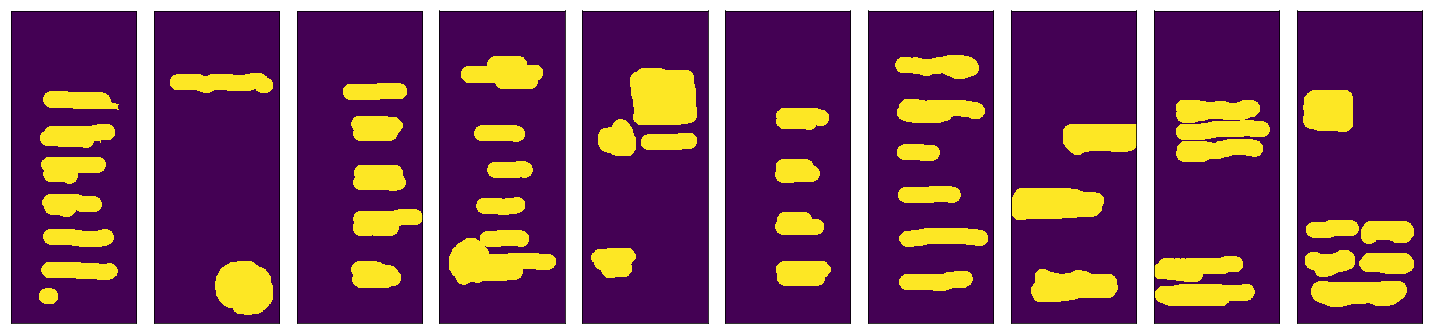

In [290]:
save_masks_one_hit(results[11])

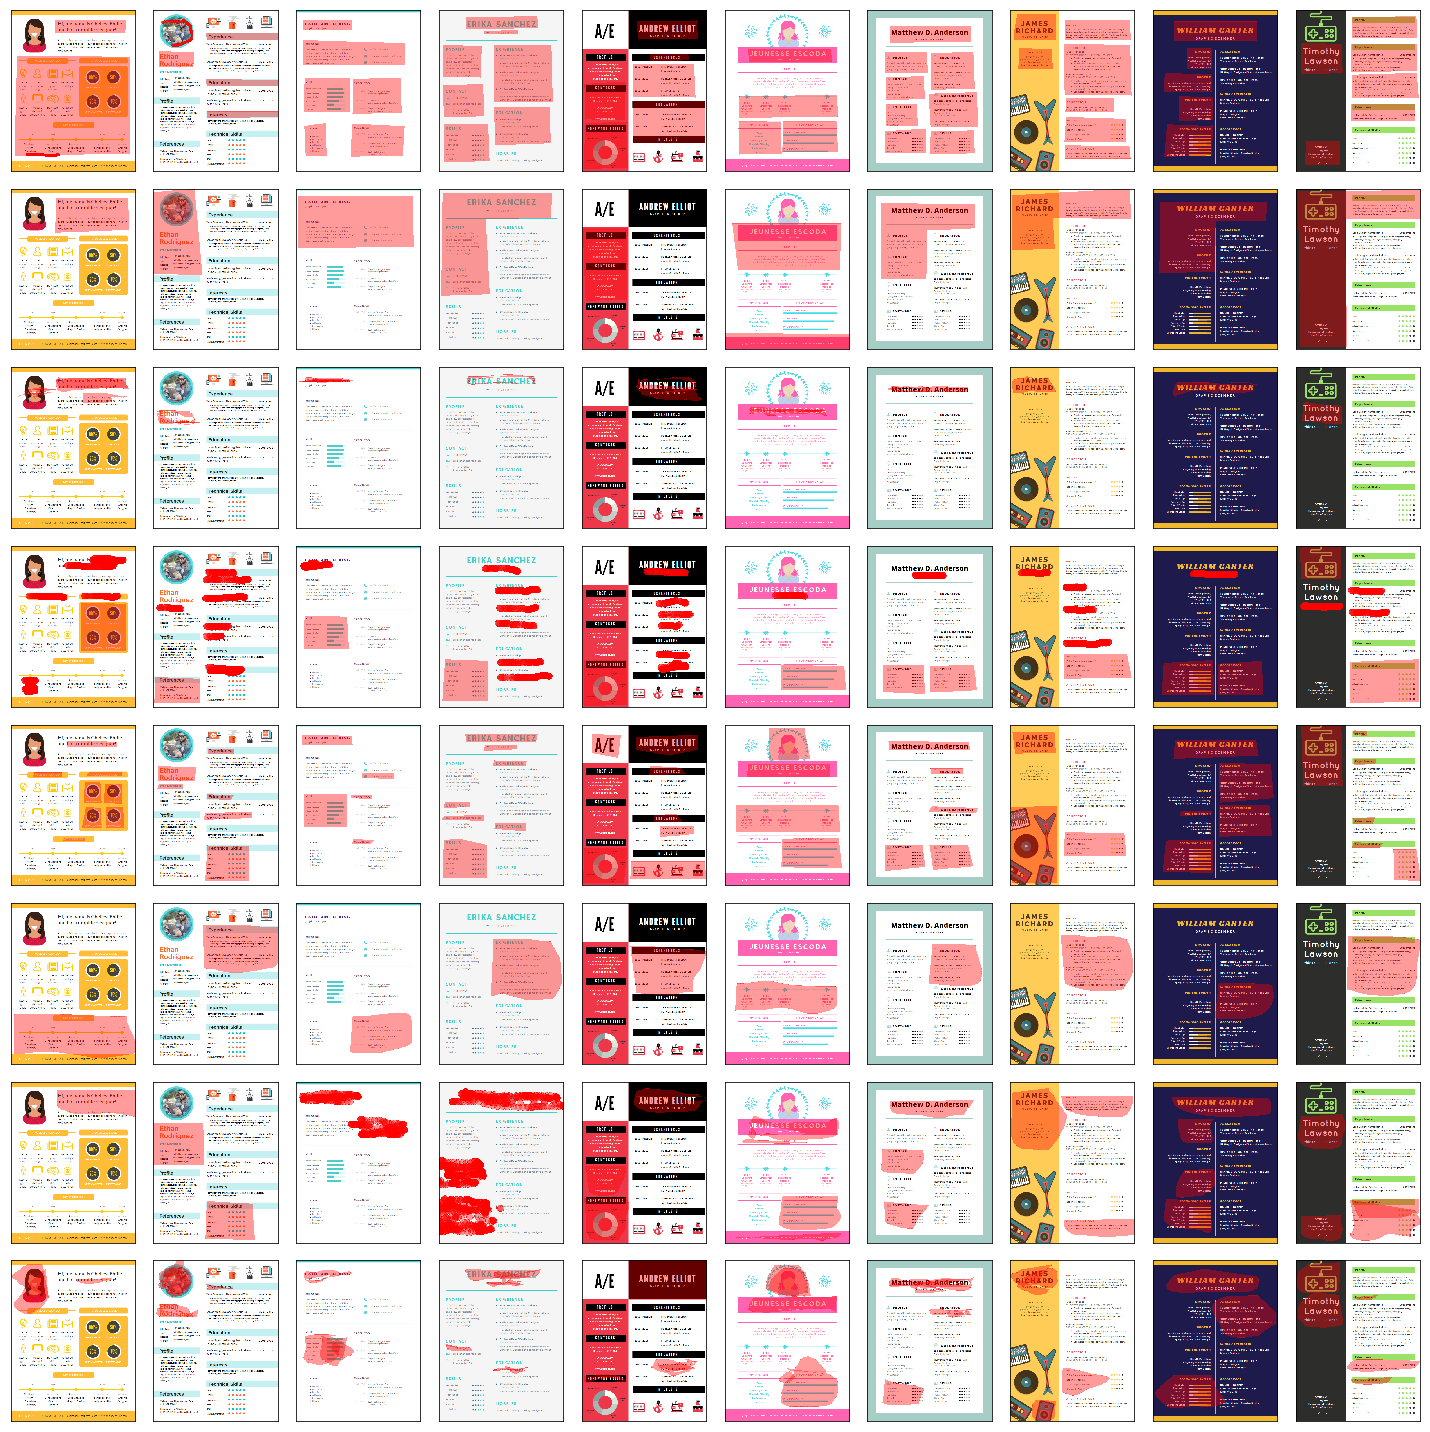

In [186]:
visualize_multiple_results(results[20:])

In [160]:
# Get Feedback

for i,r in enumerate(results):
    HITId, workerId, p_dict, feedback = extract_hit_info(r)
    print('Hit %d feedback'%i,feedback)

Hit 0 feedback My wrist started to hurt really bad doing this task. Using the Stroke Fill tool was very hard to use. 60 seconds didn't seem like enough time for some of the tasks. I was rushing trying to highlight as many things as possible before the time ran out.
Hit 1 feedback None
Hit 2 feedback thanks for letting me participate. ive never done anything like this so please dont reject if incorrect! just dont pay me lol
Hit 3 feedback None
Hit 4 feedback None
Hit 5 feedback I was able to complete 9/10 images (the timer ran out one of them) - Hopefully, I still get full credit
Hit 6 feedback None
Hit 7 feedback The images were not very much like the samples in some respects - most were blank-ish templates. I highlighted a spot on those that seemed to be a designated space for a title or headline even if not present because these were high-prominence spaces in the images, hope that's what you were looking for.
Hit 8 feedback None
Hit 9 feedback None
Hit 10 feedback None
Hit 11 feedbac

I was able to complete 9/10 images (the timer ran out one of them) - Hopefully, I still get full credit


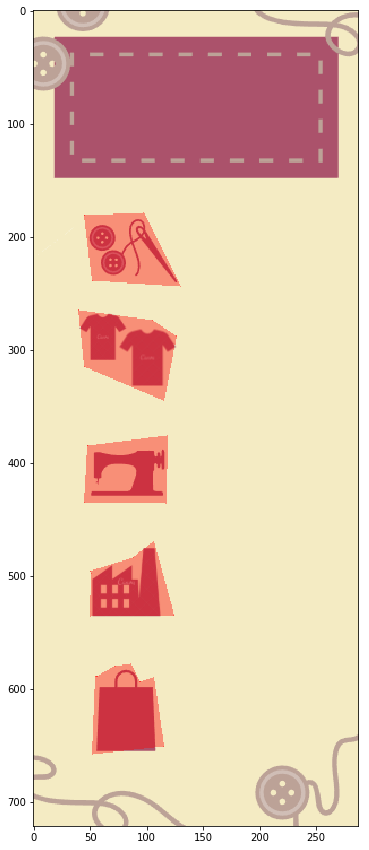

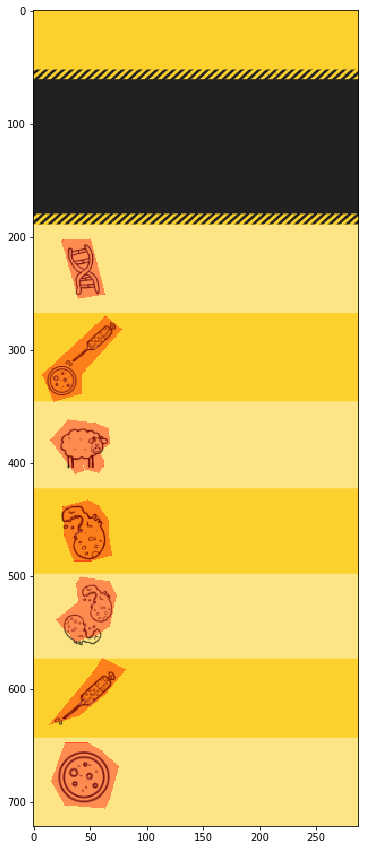

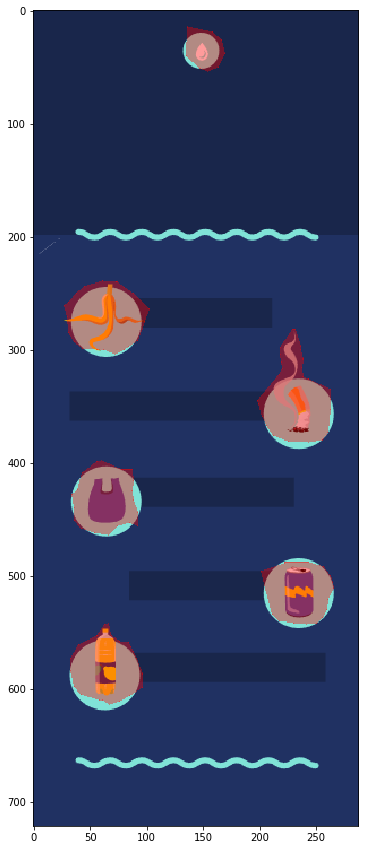

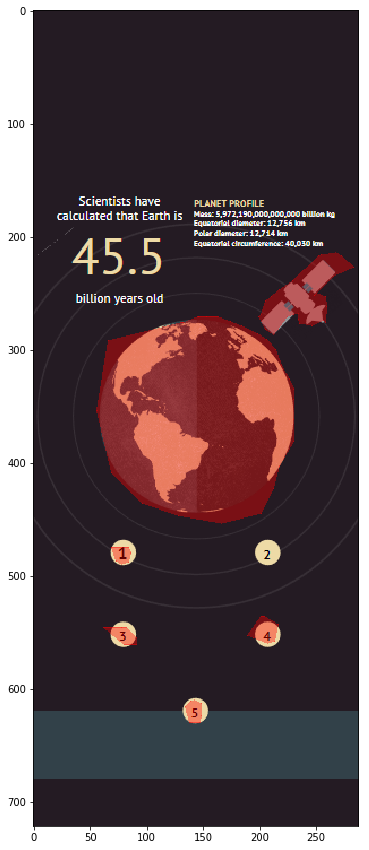

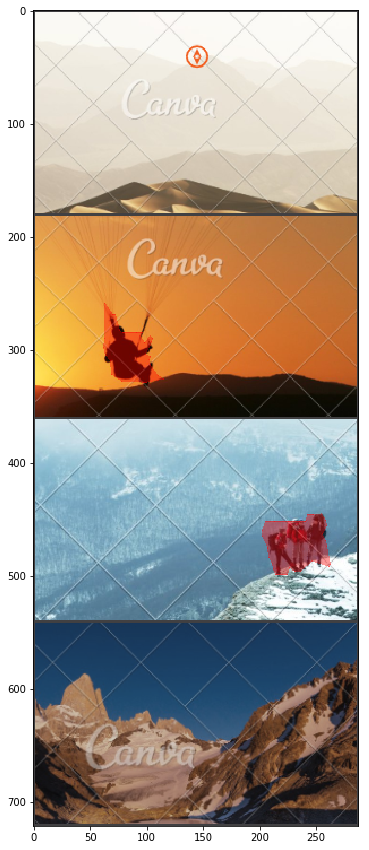

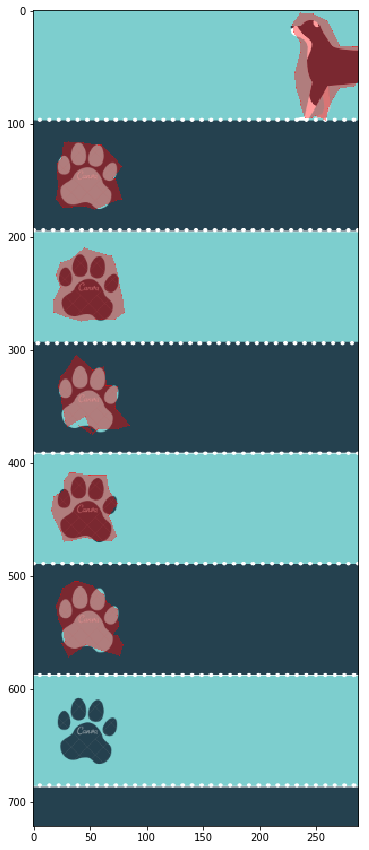

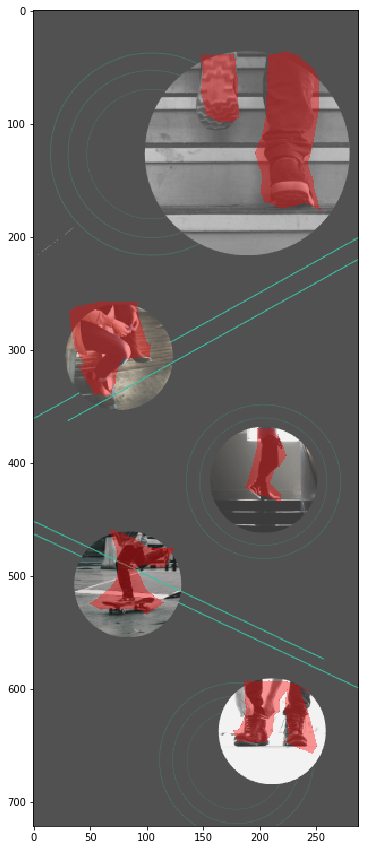

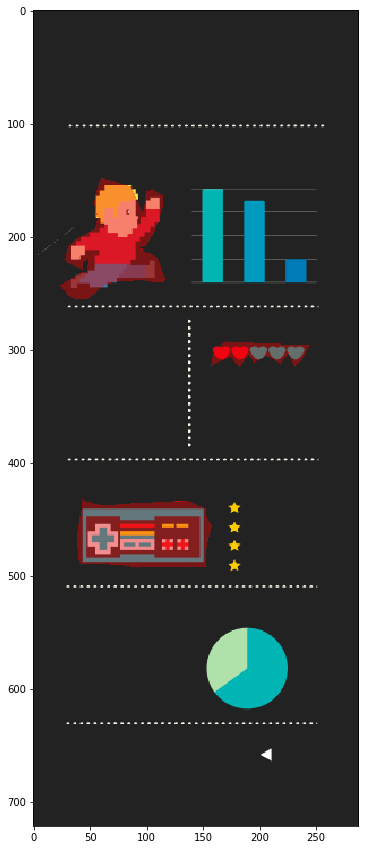

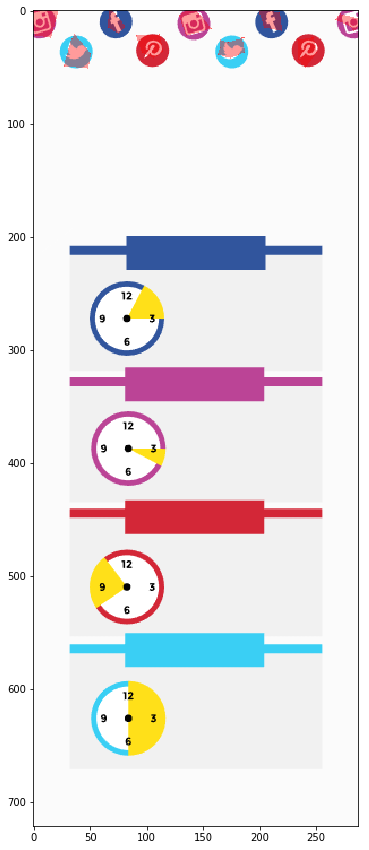

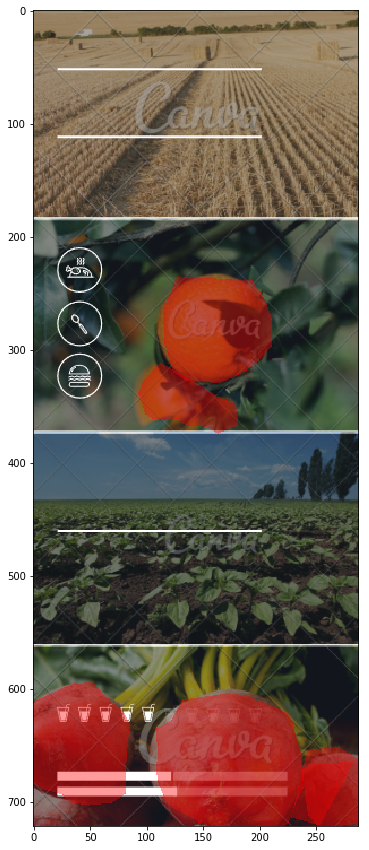

In [177]:
HITId, workerId, p_dict, feedback = extract_hit_info(results[5])

print(feedback)

for name, pts in p_dict.items():
    # Pts are dictionary of size, points
    size = pts['size']
    p = pts['points']

    visualize_polygons(name, size, p, image_from_web=True)
